In [13]:
import numpy as np
import math, csv
import pylab as pl

In [14]:
testLine = (484.0, np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
         1.,   1.,   1.,   0.,   0.,   0.,   0.,   2.,   2.,   2.,   2.,
         2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   0.,   0.,
         0.,   0.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,   3.,
         3.,   3.,   3.,   3.,   0.,   0.,   0.,   0.,   4.,   4.,   4.,
         4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   4.,   0.,
         0.,   0.,   0.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,   5.,
         5.,   5.,   5.,   5.,   5.,   0.,   0.,   0.,   0.,   6.,   6.,
         6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,   6.,
         0.,   0.,   0.,   0.,   7.,   7.,   7.,   7.,   7.,   7.,   7.,
         7.,   7.,   7.,   7.,   7.,   7.,   0.,   0.,   0.,   0.,   8.,
         8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,   8.,
         8.,   0.,   0.,   0.,   0.,   9.,   9.,   9.,   9.,   9.,   9.,
         9.,   9.,   9.,   9.,   9.,   9.,   9.,   0.,   0.,   0.,   0.,
        10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,  10.,
        10.,  10.,   0.,   0.,   0.,   0.,  11.,  11.,  11.,  11.,  11.,
        11.,  11.,  11.,  11.,  11.,  11.,  11.,  11.,   0.,   0.,   0.,
         0.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,  12.,
        12.,  12.,  12.]), np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,   0.,   0.,   0.,
         0.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,
         4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,   0.,   0.,
         0.,   0.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,
         9.,  10.,  11.,  12.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,
         3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,   0.,
         0.,   0.,   0.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,
         8.,   9.,  10.,  11.,  12.,   0.,   0.,   0.,   0.,   0.,   1.,
         2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
         0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,
         7.,   8.,   9.,  10.,  11.,  12.,   0.,   0.,   0.,   0.,   0.,
         1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,   4.,   5.,
         6.,   7.,   8.,   9.,  10.,  11.,  12.,   0.,   0.,   0.,   0.,
         0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,   0.,   0.,   0.,   0.,   0.,   1.,   2.,   3.,   4.,
         5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,   0.,   0.,   0.,
         0.,   0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,
        10.,  11.,  12.]))

<matplotlib.colorbar.Colorbar instance at 0xb000d7cc>

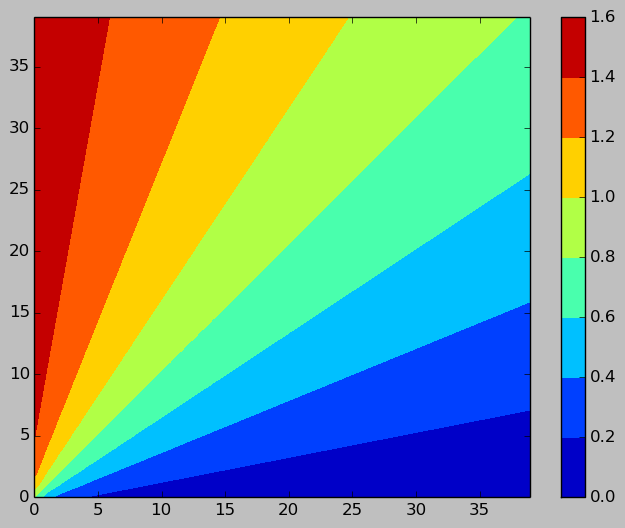

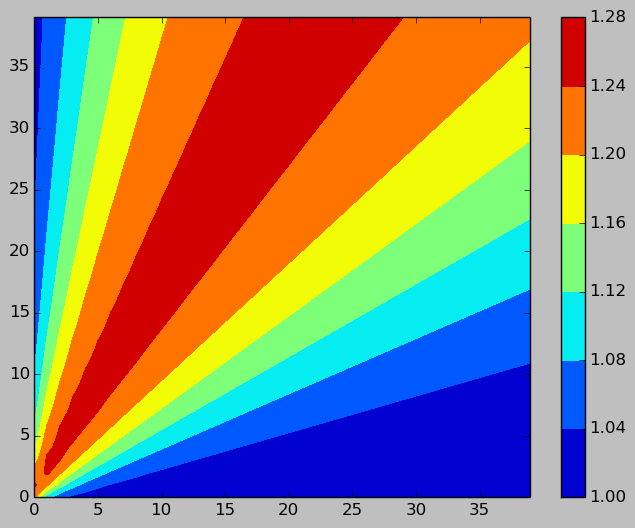

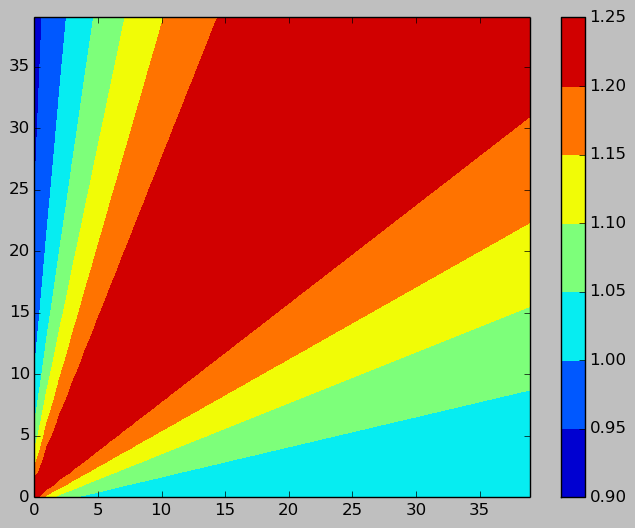

In [15]:
# import latitude, longitude, data0 and data1
LAT = np.genfromtxt('LAT.csv', delimiter=',')
LON = np.genfromtxt('LON.csv', delimiter=',')
data0 = np.genfromtxt('data0.csv', delimiter=',').astype(float)/10
data0[data0==0] = np.nan
data1 = np.genfromtxt('data1.csv', delimiter=',').astype(float)/10
data1[data1==0] = np.nan

data0KeepShape = data0.copy()
data1KeepShape = data1.copy()

pl.figure()
pl.contourf(data0)
pl.colorbar()

pl.figure()
pl.contourf(data1)
pl.colorbar()

In [16]:
# in this box we're going to define our grid and data

# find the size of the grid
gridSizeY = data0.shape[0]
gridSizeX = data0.shape[1]
testGridSize = 81
cellSize = 12500
dayLength = 24 * 60 * 60

# define indices
I, J = np.meshgrid(np.arange(0,gridSizeY),np.arange(0,gridSizeX),indexing='ij')
I = I.reshape((I.size, 1))
J = J.reshape((J.size, 1))

# define locations
XkeepShape = LON
YkeepShape = LAT
X = XkeepShape.reshape((XkeepShape.size, 1))
Y = YkeepShape.reshape((YkeepShape.size, 1))

N = np.arange(0,X.size)
NkeepShape = N.copy()

NkeepShape = NkeepShape.reshape((gridSizeY, gridSizeX))
N = N.reshape((N.size, 1))

# keep all location data in one array
locationData = np.concatenate((N,I,J,Y,X),1)

# define a don't bother with mask
''' this will contain: landmask (and half landmask to avoid footprint overlap), also mask any point with bad data'''
dontBotherMask = np.zeros_like(data0).flatten()

# produce an index for transforming data to list of (overlapping) testGrids
transformSubI = np.arange(-int(np.floor(np.sqrt(testGridSize)/2)),int(np.floor(np.sqrt(testGridSize)/2))+1,1)
transformSubI = np.tile(transformSubI.reshape(transformSubI.size, 1),(1, int(np.sqrt(testGridSize))))
transformSubI = transformSubI.reshape((1, transformSubI.size))
#print transformSubI

# produce an index for transforming data to list of (overlapping) testGrids
transformSubJ = np.arange(-int(np.floor(np.sqrt(testGridSize)/2)),int(np.floor(np.sqrt(testGridSize)/2))+1,1)
transformSubJ = np.tile(transformSubJ.reshape(1, transformSubJ.size),(int(np.sqrt(testGridSize)), 1))
transformSubJ = transformSubJ.reshape((1, transformSubJ.size))
#print transformSubJ

# broadcast the transformSubs with their big counterparts
transformSubI = transformSubI + I
transformSubJ = transformSubJ + J

#now remove the test grids if they:
#    1) contain any negative numbers in I or J
#    2) if the dontBotherMask is set
removeData = np.logical_or(np.logical_or(transformSubI<0,transformSubJ<0),
                           np.logical_or(transformSubI>=data1.shape[0],transformSubJ>=data1.shape[1]))
removeData = np.logical_or(np.any(removeData,axis=1),dontBotherMask)

transformSubI = transformSubI[removeData==0,:]
transformSubJ = transformSubJ[removeData==0,:]
locationData = locationData[removeData==0,:]
# make an RDD of the index and location data, and also a broadcast variable
locationBroadcast = sc.broadcast(locationData)

# transform the data:
data0 = data0[transformSubI,transformSubJ]
data1 = data1[transformSubI,transformSubJ]

In [17]:
NBroadcast = sc.broadcast(NkeepShape)
YBroadcast = sc.broadcast(YkeepShape)
XBroadcast = sc.broadcast(XkeepShape)

def sind(num):
    
    # return sine of angle (input is in degrees!)
    return np.sin(num * np.pi / 180)

def cosd(num):
    
    # return cosine of angle (input is in degrees!)
    return np.cos(num * np.pi / 180)

#define a function which returns the Euclidean distance between two points (in the face of the EARTH)
def distance_calc(lat1,long1,lat2,long2):
        
    R = 6371;
    
    #compute the distance between points in x, y, and z directions, and find
    #resultant distance
    straightDist = np.sqrt((R * sind(90-lat2) * cosd(long2) - R * sind(90-lat1) * cosd(long1))**2 +
        (R * sind(90-lat2) * sind(long2) - R * sind(90-lat1) * sind(long1))**2 +
        (R * cosd(90-lat2) - R * cosd(90-lat1))**2);

    #find angle between 2 points (at centre of Earth)
    alpha = 2 * np.arcsin(straightDist / (2 * R));
    
    #project angle onto spherical surface of Earth
    distance = alpha * R;
       
    return distance

def distance_calcRDD(line):
            
    Xs = XBroadcast.value[line[1].astype(int),line[2].astype(int)]
    Ys = YBroadcast.value[line[1].astype(int),line[2].astype(int)]
    x1 = Xs[np.floor(float(Xs.size)/2)]
    y1 = Ys[np.floor(float(Ys.size)/2)]
    
    distance = distance_calc(x1,y1,Xs,Ys)
    Ns = NBroadcast.value[line[1].astype(int),line[2].astype(int)]
    
    keepData = np.logical_and(np.logical_and(distance<=distThresholdBC.value,distance!=0),
                          np.any(Ns==locationBroadcast.value[:,0:1],axis=0))
    
    Ns = Ns[keepData==1]
    
    return (int(line[0]), list(Ns))
    
    
# Doing a cartesian product of every grid cell against every other grid cell is really, really inefficient.
# So, first we will filter the combinations of matches by their distance between each other on the grid.
# distGridThreshold is the maximum number of grid spaces which can be moved
# this is: max(possible distance to move)/min(possible distances between grid points)
distGridThreshold = 8

# this is the physical distance that will be the threshold for the movement of ice
# this is the distance possible to move (in km) over 1 day at 1m/s ~ (24 * 60 * 60 * 1 / 1000)
distThresholdBC = sc.broadcast(90)

# produce an index for checking distances
distCheckSubI = np.arange(-distGridThreshold,distGridThreshold+1,1)
distCheckSubI = np.tile(distCheckSubI.reshape(distCheckSubI.size, 1),(1, 2*distGridThreshold+1))
distCheckSubI = distCheckSubI.reshape((1, distCheckSubI.size))
distCheckSubI = distCheckSubI + I
distCheckSubI = distCheckSubI[removeData==0,:]

# produce an index for checking distances
distCheckSubJ = np.arange(-distGridThreshold,distGridThreshold+1,1)
distCheckSubJ = np.tile(distCheckSubJ.reshape(1, distCheckSubJ.size),(2*distGridThreshold+1, 1))
distCheckSubJ = distCheckSubJ.reshape((1, distCheckSubJ.size))
distCheckSubJ = distCheckSubJ + J
distCheckSubJ = distCheckSubJ[removeData==0,:]

# replace any data which is out of bounds with [0, 0]
badData = np.logical_or(np.logical_or(distCheckSubI<0,distCheckSubI>=XkeepShape.shape[0]),
           np.logical_or(distCheckSubJ<0,distCheckSubJ>=XkeepShape.shape[1]))

distCheckSubI[badData==1] = 0
distCheckSubJ[badData==1] = 0

# chuck the location number (which is ABSOLUTE, rather than tied to locationData size) and the indices
# into an RDD and map to a len=3 tuple
distCheckSub = np.concatenate((locationData[:,0:1],distCheckSubI,distCheckSubJ),1)
distCheckSubRDD = (sc.parallelize(distCheckSub,4)
                   .map(lambda a: (a[0],a[1:(2*distGridThreshold+1)**2+1], a[(2*distGridThreshold+1)**2+1:])))
                  
distanceDictRDD = (distCheckSubRDD
                   .map(distance_calcRDD)
                   .cache())

#print distCheckSubRDD.collect()

#print distance_calcRDD(testLine)

#print distanceDictRDD.filter(lambda (a, b): a==31).collect()
#print distanceDictRDD.take(1)

#print distCheckSubRDD.take(1)

#print distance_calcRDD(testLine)
#print locationData[0,:]
#print distCheckSub[0,:]

In [18]:
# define a function which collects the broadcast data into an RDD
# can also put correlation in here if you like
def computeCorrelation(line):
        
    # extract relevant data from the daily broadcast variables
    getdata0 = data0Broadcast.value[line[0]==locationBroadcast.value[:,0],:]
    
    grabBinary = np.any(locationBroadcast.value[:,0].reshape((locationBroadcast.value[:,0].size, 1))==line[1],axis=1)
    getdata1 = data1Broadcast.value[grabBinary,:]
            
    # tile data0 for fast correlation
    getdata0 = np.tile(getdata0-np.mean(getdata0),(getdata1.shape[0], 1))
    getdata1 = getdata1 - np.mean(getdata1,axis=1).reshape((getdata1.shape[0], 1))
    
    correl = np.sum(getdata0*getdata1,axis=1) / (np.sqrt(np.sum(getdata0*getdata0,axis=1)) * np.sqrt(np.sum(getdata1*getdata1,axis=1)))
    
    return (line[0], line[1], correl)

# find the largest correlation
'''this also needs work on: threshold value, and sharpness of peak.
Can find threshold value by computing distribution of correlations amongst motions which could never occur.
Then take 90th percentile: should remove all but 10% of bad matches.'''
def findLargestCorrel(line):
    
    correl = line[2]
    maximum = line[1][correl.argmax()]
    
    xvel = cellSize * (locationBroadcast.value[maximum==locationBroadcast.value[:,0],2] - 
            locationBroadcast.value[line[0]==locationBroadcast.value[:,0],2])
    yvel = cellSize * (locationBroadcast.value[maximum==locationBroadcast.value[:,0],1] - 
            locationBroadcast.value[line[0]==locationBroadcast.value[:,0],1])
        
    i = locationBroadcast.value[line[0]==locationBroadcast.value[:,0],1]
    j = locationBroadcast.value[line[0]==locationBroadcast.value[:,0],2]
    
    return (np.hstack((i, j)), np.hstack((yvel,xvel)))


In [19]:
# turn data0 and data1 into broadcast variables
data0Broadcast = sc.broadcast(data0)
data1Broadcast = sc.broadcast(data1)

correlationRDD = (distanceDictRDD
            .map(computeCorrelation)
            .map(findLargestCorrel)
            .cache())
            
#print correlationRDD.collect()
#print np.arange(0,100).reshape((10,10))

In [20]:
# now need to reconstruct original data format
# to do this, we are going to collect 2 RDDS

# one for the location of output
outputLocation = np.array(correlationRDD
                 .flatMap(lambda (a, b): a)
                 .collect())
outputLocation = outputLocation.reshape((outputLocation.size/2, 2)).astype(int)

# one for the distance travelled
outputDist = np.array(correlationRDD
                 .flatMap(lambda (a, b): b)
                 .collect())
outputDist = outputDist.reshape((outputDist.size/2, 2))


<matplotlib.colorbar.Colorbar instance at 0xb0e311ec>

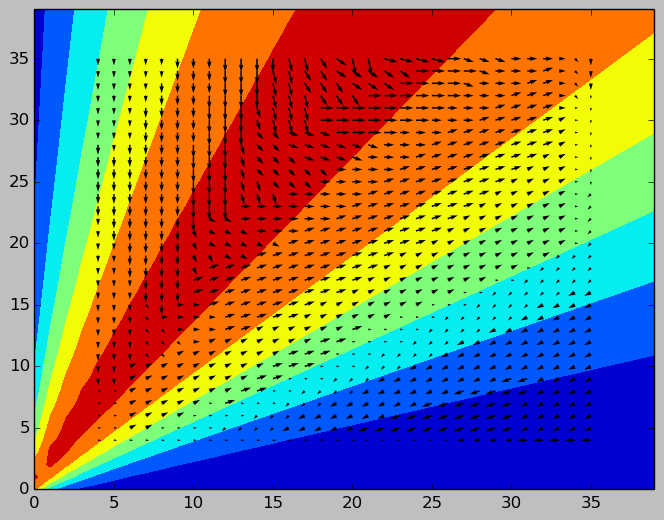

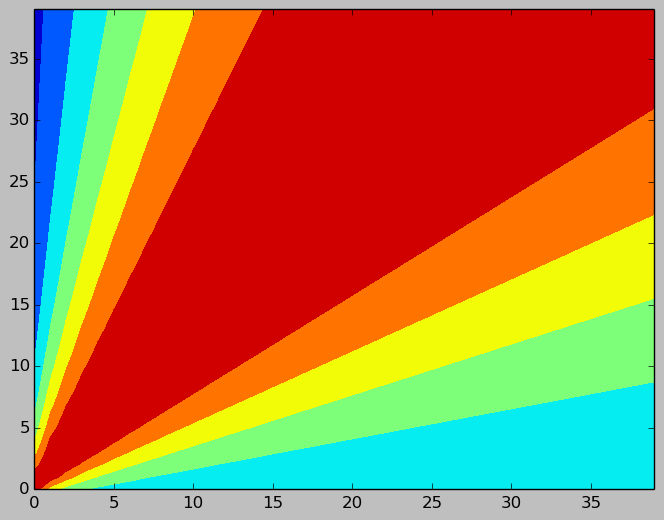

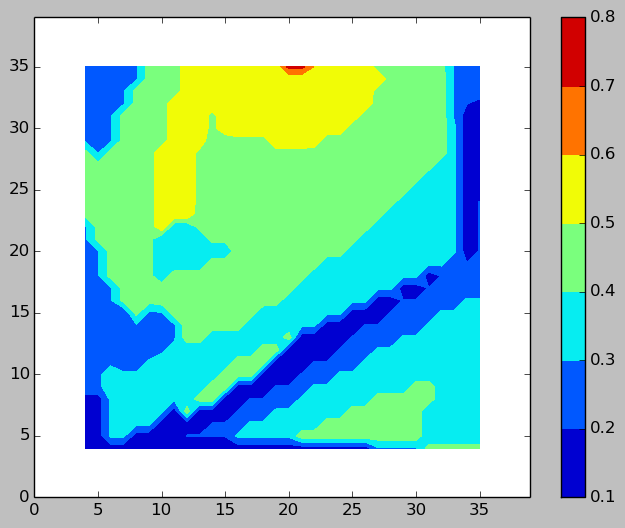

In [21]:
yDist = np.ones((gridSizeY,gridSizeX))*np.nan
xDist = np.ones((gridSizeY,gridSizeX))*np.nan

# extract x and y distances and divide by time
yDist[outputLocation[:,0],outputLocation[:,1]] = outputDist[:,0]/dayLength
xDist[outputLocation[:,0],outputLocation[:,1]] = outputDist[:,1]/dayLength


pl.figure()
pl.contourf(data0KeepShape)
pl.quiver(xDist,yDist)

#keepI1 = 60
#keepI2 = 100
#keepJ1 = 0
#keepJ2 = 30

#pl.xlim( (keepJ1, keepJ2) )
#pl.ylim( (keepI1, keepI2) )

pl.figure()
pl.contourf(data1KeepShape)


pl.figure()
pl.contourf(np.sqrt(xDist**2+yDist**2))
pl.colorbar()

#keepI1 = 10
#keepI2 = 70
#keepJ1 = 10
#keepJ2 = 70

#xlim( (keepJ1, keepJ2) )
#ylim( (keepI1, keepI2) )

